In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from sys import stderr
from functools import reduce
from operator import mul

CONTENT_LAYER = 'relu4_2'
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

In [3]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        # grayscale
        img = np.dstack((img,img,img))
    return img

def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
    

def create_net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net, mean_pixel


def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def _tensor_size(tensor):
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

def preprocess(image, mean_pixel):
    return image - mean_pixel


def unprocess(image, mean_pixel):
    return image + mean_pixel

In [4]:
# parameters setup
network = "imagenet-vgg-verydeep-19.mat"
content_dir = "examples/face.jpg"
styles_dir = ["examples/wave.jpg"]
num_steps = 1000
content_weight = 5e0
style_weight = 1e2
style_blend_weights = [1]
tv_weight = 1e2
print_iterations = 50
checkpoint_iterations = 50

In [5]:
# read image as matrix
content = imread(content_dir)
styles = [imread(style) for style in styles_dir]
target_shape = content.shape
for i in range(len(styles)):
    styles[i] = scipy.misc.imresize(styles[i], target_shape[1] / styles[i].shape[1])

In [6]:
shape = (1,) + content.shape
style_shapes = [(1,) + style.shape for style in styles]
content_features = {}
style_features = [{} for _ in styles]

# compute content features in feedforward mode
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net, mean_pixel = create_net(network, image)
    content_pre = np.array([preprocess(content, mean_pixel)])
    content_features[CONTENT_LAYER] = net[CONTENT_LAYER].eval(
            feed_dict={image: content_pre})
    print("content features shape for {}: {}".format(CONTENT_LAYER, content_features[CONTENT_LAYER].shape))

# compute style features in feedforward mode
for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
        image = tf.placeholder('float', shape=style_shapes[i])
        net, _ = create_net(network, image)
        style_pre = np.array([preprocess(styles[i], mean_pixel)])
        for layer in STYLE_LAYERS:
            features = net[layer].eval(feed_dict={image: style_pre})
            print("style features shape for {}: {}".format(layer, features.shape))
            # change features shape from (1, height, width, channels) to (height * width, channels)
            features = np.reshape(features, (-1, features.shape[3]))
            # shape of gram (num_node, channels)
            gram = np.matmul(features.T, features) / features.size
            style_features[i][layer] = gram

content features shape for relu4_2: (1, 109, 75, 512)
style features shape for relu1_1: (1, 330, 597, 64)
style features shape for relu2_1: (1, 165, 299, 128)
style features shape for relu3_1: (1, 83, 150, 256)
style features shape for relu4_1: (1, 42, 75, 512)
style features shape for relu5_1: (1, 21, 38, 512)


In [ ]:
# make stylized image using backpropogation
graph = tf.Graph()
with graph.as_default(), graph.device('/cpu:0'):
    # init image
    noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
    initial = tf.random_normal(shape) * 0.256
    image = tf.Variable(initial)
    net, _ = create_net(network, image)

    # content loss
    content_loss = content_weight * tf.nn.l2_loss(
            net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) / content_features[CONTENT_LAYER].size
    
    # style loss
    style_loss = 0
    for i in range(len(styles)):
        style_losses = []
        for style_layer in STYLE_LAYERS:
            layer = net[style_layer]
            # get shape of the layer
            _, height, width, number = map(lambda i: i.value, layer.get_shape())
            size = height * width * number
            # feats shape: (height * width, channels)
            feats = tf.reshape(layer, (-1, number))
            gram = tf.matmul(tf.transpose(feats), feats) / size
            style_gram = style_features[i][style_layer]
            style_losses.append(tf.nn.l2_loss(gram - style_gram) / style_gram.size)
        style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)
        
    # total variation denoising
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * (
            (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                tv_y_size) +
            (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                tv_x_size))
    # overall loss
    loss = content_loss + style_loss + tv_loss

    # learning rate
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(10.0, global_step, 1000, 0.1, staircase=False)

    # optimizer setup
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # optimization
    best_loss = float('inf')
    best = None


Average loss at step 0: 23887112.000000 learning rate: 10.000000


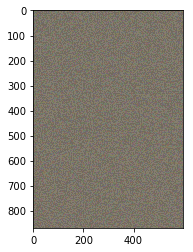

Average loss at step 1: 21242554.000000 learning rate: 9.977000


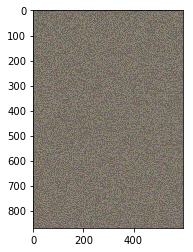

Average loss at step 2: 15198163.000000 learning rate: 9.954054


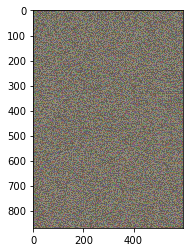

Average loss at step 3: 14249456.000000 learning rate: 9.931160


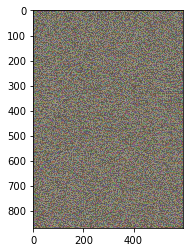

Average loss at step 4: 10638526.000000 learning rate: 9.908319


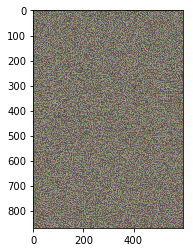

Average loss at step 5: 8516339.000000 learning rate: 9.885531


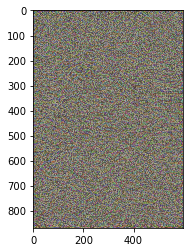

Average loss at step 6: 7357751.500000 learning rate: 9.862795


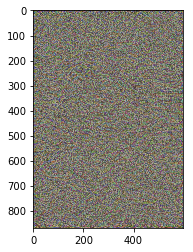

Average loss at step 7: 6639940.000000 learning rate: 9.840111


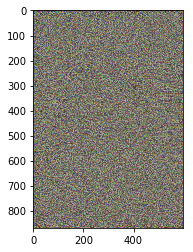

Average loss at step 8: 6094636.500000 learning rate: 9.817479


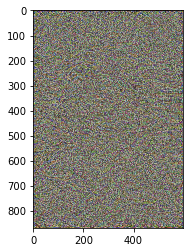

Average loss at step 9: 5651161.500000 learning rate: 9.794900


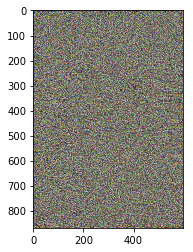

Average loss at step 10: 5205208.000000 learning rate: 9.772372


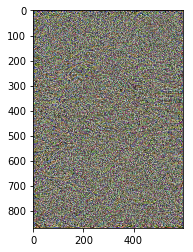

Average loss at step 11: 4794855.000000 learning rate: 9.749897


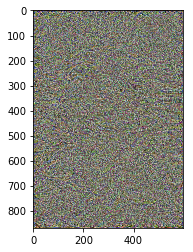

Average loss at step 12: 4382936.500000 learning rate: 9.727472


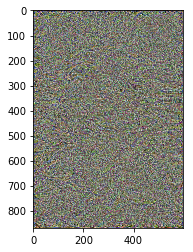

In [ ]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        last_step = (step == num_steps - 1)
        _, lr, l = sess.run([optimizer, learning_rate, loss])
        if (checkpoint_iterations and step % checkpoint_iterations == 0) or last_step:
            print(
                'Average loss at step %d: %f learning rate: %f' % (step, l, lr))
            if l < best_loss:
                best_loss = l
                best = image.eval()
                output = unprocess(best.reshape(shape[1:]), mean_pixel)
                plt.imshow(np.clip(output, 0, 255).astype(np.uint8))
                plt.show()

In [ ]:
imsave('face2.jpg', output)

In [ ]:
# plt.figure(figsize = (15, 15))
# plt.imshow(np.clip(output, 0, 255).astype(np.uint8))